In [76]:
import pandas as pd
import numpy as np
import sqlite3
import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.svm import SVR, LinearSVR

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 감가된 컬럼 = ['salvage_value']

In [3]:
con = sqlite3.connect('car_info_final_0613.db')
df = pd.read_sql('SELECT * FROM df_car_info_final', con)
con.close()

df['내용연수'] = (2022 - df['year'])

for i in range(0, len(df['내용연수'])):
    if df['내용연수'][i] > 15:
        df['내용연수'][i] = 15

C:\Users\NNYG\AppData\Local\Temp/ipykernel_29112/631335744.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['내용연수'][i] = 15


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9432 entries, 0 to 9431
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   manufacturer  9432 non-null   object
 1   model         9432 non-null   object
 2   price         9432 non-null   int64 
 3   year          9432 non-null   int64 
 4   km            9432 non-null   int64 
 5   fuel          9432 non-null   int64 
 6   cc            9432 non-null   int64 
 7   color         9432 non-null   object
 8   accident      9432 non-null   int64 
 9   simple_model  9432 non-null   object
 10  og_price      9432 non-null   int64 
 11  내용연수          9432 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 884.4+ KB


In [5]:
models = df['simple_model'].unique()

models

array(['K5', '스포티지', '쏘렌토', '봉고', '카니발', 'K9', '모닝', 'K7', '모하비', '리오',
       '쏘울', '포텐샤', 'K3', '포르테', '프라이드', '옵티마리갈', '레이', '카렌스', '로체', '니로',
       '오피러스', '셀토스', '카스타', '스팅어', '스토닉', 'K8', '비스토터보', '쎄라토', 'EQ900',
       'G80', 'G70', 'G90', 'GV80', 'GV70', '크루즈', '스파크', '윈스톰', '라보',
       '마티즈', '올란도', '트랙스', '아베오', '라세티', '캡티바', '젠트라', '다마스', '토스카',
       '말리부', '알페온', '트레일블레이저', '레조', '임팔라', '카마로', '이쿼녹스', '콜로라도',
       '트래버스', '렉스턴', '액티언', '티볼리', '코란도', '체어맨', '무쏘', '카이런', '로디우스',
       'SM6', 'SM5', 'QM3', 'SM7', 'QM6', 'SM3', 'QM5', '클리오', 'XM3',
       '마스터 밴', '그랜저', 'BH330', '쏘나타', '스타렉스', '포터', '투싼', '에쿠스', '베라크루즈',
       'DHG330', '갤로퍼', '싼타페', '그레이스', '아반떼', '벨로스터', '맥스크루즈', '아슬란',
       'DHG380', 'i30', 'BH380', '코나', '제네시스 쿠페', '엑센트', '베르나', 'i40',
       '테라칸', '투스카니', '펠리세이드', '트라제', '캐스퍼', '다이너스티', '베뉴', '뉴클릭', '아이오닉'],
      dtype=object)

In [6]:
df.columns
col = ['manufacturer', 'model', 'price', 'year', 'km', 'fuel', 'cc', 'color', 'accident', 'simple_model', 'og_price', '내용연수', '연평균_감가상각비']

df_model_sal = pd.DataFrame(columns = col)
for i in models :
    tmp_df = df[df['simple_model'] == i]
    tmp_df['연평균_감가상각비'] = (((tmp_df['og_price'] - tmp_df['price']) / tmp_df['og_price']) * 100) / (tmp_df['내용연수'])
    tmp_df = tmp_df.replace([np.inf, -np.inf], np.nan)
    tmp_df = tmp_df.fillna(0)
    df_model_sal = df_model_sal.append(tmp_df)

df_model_sal.set_index(np.arange(0, len(df['model'])), inplace = True)

C:\Users\NNYG\AppData\Local\Temp/ipykernel_29112/4079068246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['연평균_감가상각비'] = (((tmp_df['og_price'] - tmp_df['price']) / tmp_df['og_price']) * 100) / (tmp_df['내용연수'])


In [7]:
# 연료별로 나누기 휘발유
# 차량별로 나누기 K5
# 연도별로 나누기 2021
df_model_sal

,manufacturer,model,price,year,km,fuel,cc,color,accident,simple_model,og_price,내용연수,연평균_감가상각비
0,기아,K52.0 LPI 디럭스,1250,2011,83844,2,2000,whitish,1,K5,1728,11,2.514731
1,기아,K5 2세대2.0 가솔린 SX 프레스티지,1900,2016,15751,0,1999,whitish,1,K5,2705,6,4.959951
2,기아,K5 하이브리드럭셔리,920,2012,138733,4,2000,whitish,1,K5,3046,10,6.979645
3,기아,K5 2세대1.6 터보 가솔린 SX 노블레스 스페셜,1850,2016,30069,0,1998,whitish,1,K5,3030,6,6.490649
4,기아,K5 하이브리드프레스티지,1070,2012,90000,4,1999,blackish,1,K5,3178,10,6.633103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9427,현대,뉴클릭1.4 DOHC w 기본형,270,2007,129208,0,1399,etc,1,뉴클릭,864,15,4.583333
9428,현대,더 뉴 아이오닉N,2550,2020,14007,4,1580,whitish,0,아이오닉,2628,2,1.484018
9429,현대,아이오닉P-HEV N,1630,2016,80997,4,1580,blackish,0,아이오닉,2638,6,6.368461
9430,현대,아이오닉I,1040,2016,172741,4,1580,whitish,1,아이오닉,2438,6,9.557014


# 연료별

In [8]:
df_petrol = df_model_sal[df_model_sal['fuel'] == 0]
df_diesel = df_model_sal[df_model_sal['fuel'] == 1]
df_lpg = df_model_sal[df_model_sal['fuel'] == 2]
df_hev = df_model_sal[df_model_sal['fuel'] == 4]

In [9]:
df_petrol['연평균_감가상각비'].mean()

7.253327937120127

# 휘발유

In [17]:
df_sal_petrol = pd.DataFrame(columns = ['model', '2021', '2020', '2019'])
df_sal_petrol

for i in df_petrol['simple_model'].unique():
    tmp_model = df_petrol[df_petrol['simple_model'] == i]
    
    globals()['list_' + str(i)] = []
    
    tmp_model_2021 = tmp_model[tmp_model['year'] == 2021]
    a = tmp_model_2021['연평균_감가상각비'].mean()
    
    tmp_model_2020 = tmp_model[tmp_model['year'] == 2020]
    b = tmp_model_2020['연평균_감가상각비'].mean() * 2
    
    tmp_model_2019 = tmp_model[tmp_model['year'] == 2019]
    c = tmp_model_2019['연평균_감가상각비'].mean() * 3
    
    
    tmp_models = [[i, a , b, c]]
    
    tmp_df_models = pd.DataFrame(tmp_models, columns = ['model', '2021', '2020', '2019'])
    tmp_mean =  df_petrol['연평균_감가상각비'].mean()
    tmp_df_models['2021'] = tmp_df_models['2021'].fillna(tmp_mean)
    tmp_df_models['2020'] = tmp_df_models['2020'].fillna(tmp_mean * 2)
    tmp_df_models['2019'] = tmp_df_models['2019'].fillna(tmp_mean * 3)
    
    
    # df_sal_petrol = df_sal_petrol.append(pd.Series(tmp_models, index = df_sal_petrol.columns), ignore_index = True)
    df_sal_petrol = pd.concat([df_sal_petrol, tmp_df_models], axis = 0)

df_sal_petrol.head(30)

,model,2021,2020,2019
0,K5,-3.786732,8.332205,30.761232
0,스포티지,7.253328,14.506656,6.105892
0,쏘렌토,7.253328,7.468423,4.880053
0,카니발,7.253328,14.506656,8.753234
0,K9,23.507682,27.207658,37.943920
0,모닝,4.870680,19.784021,-3.055556
0,K7,7.253328,21.545097,33.930196
0,모하비,7.253328,14.506656,21.759984
0,리오,7.253328,14.506656,21.759984
0,쏘울,7.253328,14.506656,4.964723


# 디젤

In [11]:
df_diesel.head()

,manufacturer,model,price,year,km,fuel,cc,color,accident,simple_model,og_price,내용연수,연평균_감가상각비
7,기아,더 뉴 K5 2세대1.7 디젤 프레스티지,1190,2016,82525,1,1685,blackish,0,K5,2547,6,8.879728
46,기아,K5 2세대1.7 디젤 MX 럭셔리,1400,2016,105535,1,1700,blackish,1,K5,2950,6,8.757062
52,기아,K5 2세대1.7 디젤 MX 노블레스,1230,2016,137956,1,1700,whitish,1,K5,2950,6,9.717514
153,기아,K5 2세대1.7 디젤 SX 프레스티지,1350,2016,71639,1,1685,blackish,1,K5,2950,6,9.039548
160,기아,더 뉴 K5 2세대1.7 디젤 프레스티지,1660,2019,41448,1,1685,greyish,0,K5,2547,3,11.608428


In [12]:
df_sal_diesel = pd.DataFrame(columns = ['model', '2021', '2020', '2019'])
df_sal_diesel

for i in df_diesel['simple_model'].unique():
    tmp_model = df_diesel[df_diesel['simple_model'] == i]
    
    globals()['list_' + str(i)] = []
    
    tmp_model_2021 = tmp_model[tmp_model['year'] == 2021]
    a = tmp_model_2021['연평균_감가상각비'].mean()
    
    tmp_model_2020 = tmp_model[tmp_model['year'] == 2020]
    b = tmp_model_2020['연평균_감가상각비'].mean() * 2
    
    tmp_model_2019 = tmp_model[tmp_model['year'] == 2019]
    c = tmp_model_2019['연평균_감가상각비'].mean() * 3
    
    
    tmp_models = [[i, a , b, c]]
    
    tmp_df_models = pd.DataFrame(tmp_models, columns = ['model', '2021', '2020', '2019'])
    tmp_mean =  df_diesel['연평균_감가상각비'].mean()
    tmp_df_models['2021'] = tmp_df_models['2021'].fillna(tmp_mean)
    tmp_df_models['2020'] = tmp_df_models['2020'].fillna(tmp_mean * 2)
    tmp_df_models['2019'] = tmp_df_models['2019'].fillna(tmp_mean * 3)
    
    
    # df_sal_petrol = df_sal_petrol.append(pd.Series(tmp_models, index = df_sal_petrol.columns), ignore_index = True)
    df_sal_diesel = pd.concat([df_sal_diesel, tmp_df_models], axis = 0)

df_sal_diesel.head(50)

,model,2021,2020,2019
0,K5,6.619553,13.239106,35.021594
0,스포티지,6.619553,13.307985,22.190683
0,쏘렌토,4.017621,16.090903,24.512760
0,봉고,-1.856043,1.762978,11.455593
0,카니발,-10.018067,21.812082,26.430614
0,K7,6.619553,19.582245,37.032777
0,모하비,13.818107,17.943953,27.949764
0,쏘울,6.619553,13.239106,19.858659
0,K3,6.619553,13.239106,19.858659
0,프라이드,6.619553,13.239106,19.858659


# LPG

In [13]:
df_lpg

,manufacturer,model,price,year,km,fuel,cc,color,accident,simple_model,og_price,내용연수,연평균_감가상각비
0,기아,K52.0 LPI 디럭스,1250,2011,83844,2,2000,whitish,1,K5,1728,11,2.514731
5,기아,K5 2세대렌터카 2.0 LPI SX 럭셔리,1490,2017,38000,2,1999,whitish,0,K5,1860,5,3.978495
10,기아,더 뉴 K5LPI 프레스티지 경제형,1350,2014,90000,2,1999,whitish,1,K5,2160,8,4.687500
13,기아,K52.0 LPI 럭셔리,760,2011,103603,2,2000,whitish,1,K5,1860,11,5.376344
15,기아,K52.0 LPI 프레스티지,1090,2012,140243,2,1999,whitish,1,K5,2035,10,4.643735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8819,현대,더 뉴 아반떼1.6 LPi 스마트 렌터카,560,2015,192017,2,1591,whitish,1,아반떼,1688,7,9.546378
8832,현대,더 뉴 아반떼 AD장애인용 1.6 LPi 모던,1850,2020,19796,2,1591,whitish,1,아반떼,2141,2,6.795890
8850,현대,더 뉴 아반떼 AD렌터카 1.6 LPi 스마트,1239,2020,134734,2,1582,whitish,0,아반떼,1868,2,16.836188
8882,현대,더 뉴 아반떼1.6 LPi 스타일 렌터카,389,2014,220000,2,1600,greyish,1,아반떼,1387,8,8.994232


In [14]:
df_sal_lpg = pd.DataFrame(columns = ['model', '2021', '2020', '2019'])
df_sal_lpg

for i in df_lpg['simple_model'].unique():
    tmp_model = df_lpg[df_lpg['simple_model'] == i]
    
    globals()['list_' + str(i)] = []
    
    tmp_model_2021 = tmp_model[tmp_model['year'] == 2021]
    a = tmp_model_2021['연평균_감가상각비'].mean()
    
    tmp_model_2020 = tmp_model[tmp_model['year'] == 2020]
    b = tmp_model_2020['연평균_감가상각비'].mean() * 2
    
    tmp_model_2019 = tmp_model[tmp_model['year'] == 2019]
    c = tmp_model_2019['연평균_감가상각비'].mean() * 3
    
    
    tmp_models = [[i, a , b, c]]
    
    tmp_df_models = pd.DataFrame(tmp_models, columns = ['model', '2021', '2020', '2019'])
    tmp_mean =  df_lpg['연평균_감가상각비'].mean()
    tmp_df_models['2021'] = tmp_df_models['2021'].fillna(tmp_mean)
    tmp_df_models['2020'] = tmp_df_models['2020'].fillna(tmp_mean * 2)
    tmp_df_models['2019'] = tmp_df_models['2019'].fillna(tmp_mean * 3)
    
    
    # df_sal_petrol = df_sal_petrol.append(pd.Series(tmp_models, index = df_sal_petrol.columns), ignore_index = True)
    df_sal_lpg = pd.concat([df_sal_lpg, tmp_df_models], axis = 0)

df_sal_lpg.head(30)

,model,2021,2020,2019
0,K5,7.827267,17.052212,28.987758
0,봉고,7.827267,16.719768,1.365706
0,카니발,7.827267,15.654534,23.481801
0,모닝,7.827267,15.654534,23.481801
0,K7,1.422107,15.141844,36.915764
0,옵티마리갈,7.827267,15.654534,23.481801
0,레이,7.827267,15.654534,23.481801
0,카렌스,7.827267,15.654534,23.481801
0,로체,7.827267,15.654534,23.481801
0,오피러스,7.827267,15.654534,23.481801


# HEV

In [15]:
df_hev

,manufacturer,model,price,year,km,fuel,cc,color,accident,simple_model,og_price,내용연수,연평균_감가상각비
2,기아,K5 하이브리드럭셔리,920,2012,138733,4,2000,whitish,1,K5,3046,10,6.979645
4,기아,K5 하이브리드프레스티지,1070,2012,90000,4,1999,blackish,1,K5,3178,10,6.633103
6,기아,K5 하이브리드프레스티지,780,2012,240000,4,1999,greyish,0,K5,3178,10,7.545626
8,기아,K5 하이브리드500H 프레스티지,1290,2014,74500,4,1999,whitish,1,K5,3178,8,7.426054
9,기아,K5 하이브리드럭셔리,995,2013,133000,4,1999,blackish,0,K5,3046,9,7.481579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9315,현대,베르나(신형,250,2009,58670,4,1400,greyish,1,베르나,854,13,5.440461
9428,현대,더 뉴 아이오닉N,2550,2020,14007,4,1580,whitish,0,아이오닉,2628,2,1.484018
9429,현대,아이오닉P-HEV N,1630,2016,80997,4,1580,blackish,0,아이오닉,2638,6,6.368461
9430,현대,아이오닉I,1040,2016,172741,4,1580,whitish,1,아이오닉,2438,6,9.557014


In [16]:
df_sal_hev = pd.DataFrame(columns = ['model', '2021', '2020', '2019'])
df_sal_hev

for i in df_hev['simple_model'].unique():
    tmp_model = df_hev[df_hev['simple_model'] == i]
    
    globals()['list_' + str(i)] = []
    
    tmp_model_2021 = tmp_model[tmp_model['year'] == 2021]
    a = tmp_model_2021['연평균_감가상각비'].mean()
    
    tmp_model_2020 = tmp_model[tmp_model['year'] == 2020]
    b = tmp_model_2020['연평균_감가상각비'].mean() * 2
    
    tmp_model_2019 = tmp_model[tmp_model['year'] == 2019]
    c = tmp_model_2019['연평균_감가상각비'].mean() * 3
    
    
    tmp_models = [[i, a , b, c]]
    
    tmp_df_models = pd.DataFrame(tmp_models, columns = ['model', '2021', '2020', '2019'])
    tmp_mean =  df_hev['연평균_감가상각비'].mean()
    tmp_df_models['2021'] = tmp_df_models['2021'].fillna(tmp_mean)
    tmp_df_models['2020'] = tmp_df_models['2020'].fillna(tmp_mean * 2)
    tmp_df_models['2019'] = tmp_df_models['2019'].fillna(tmp_mean * 3)
    
    
    # df_sal_petrol = df_sal_petrol.append(pd.Series(tmp_models, index = df_sal_petrol.columns), ignore_index = True)
    df_sal_hev = pd.concat([df_sal_hev, tmp_df_models], axis = 0)

df_sal_hev.head(30)

,model,2021,2020,2019
0,K5,-8.010801,10.799578,37.401699
0,스포티지,7.995064,15.990127,23.985191
0,쏘렌토,-3.304308,15.990127,23.985191
0,봉고,34.408602,37.332469,23.985191
0,K7,38.494569,8.542760,31.614940
0,포르테,7.995064,15.990127,23.985191
0,니로,7.995064,46.954669,23.985191
0,K8,7.995064,15.990127,23.985191
0,말리부,7.995064,15.990127,23.985191
0,알페온,7.995064,15.990127,23.985191


# 그래프

### 입력데이터
- 모델명
- 연식
- 연료

====================================== 검색한 차량의 정보가 없습니다. ===============================================


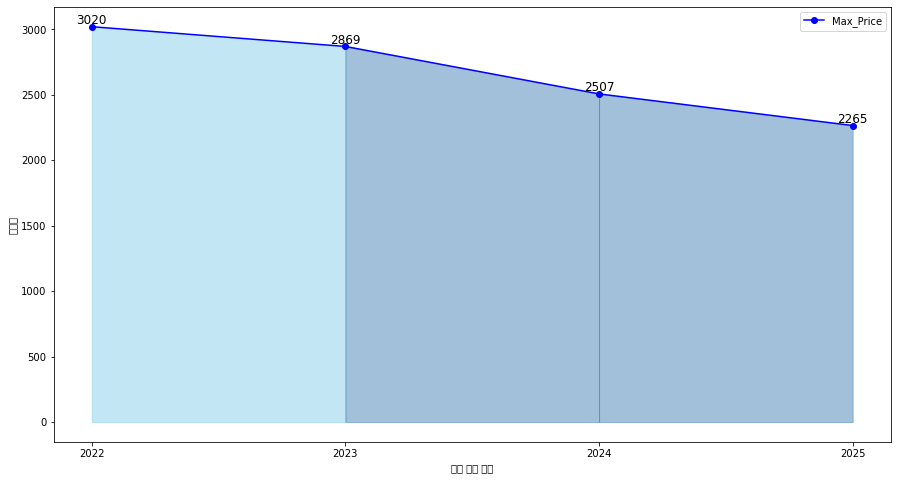

In [187]:
# input_model = str(input('모델을 입력하세요 : >>>') )
# input_year = int(input('연식을 입력하세요 : >>>'))
# input_fuel = int(input('원하는 연료의 숫자를 선택하세요 (0 -> 가솔린, 1 -> 디젤, 2 -> LPG, 4 -> 하이브리드) : >>>'))

input_model = '쏘렌토'
input_year = 2020
input_fuel = 1

if input_fuel == 0:
    str_fuel = '가솔린'
elif input_fuel == 1:
    str_fuel = '디젤'
elif input_fuel == 2:
    str_fuel = 'LPg'
else :
    str_fuel = '하이브리드'



try :
    tmp_search_1 = df[df['simple_model'] == input_model]
    tmp_search_2 = tmp_search_1[tmp_search_1['year'] == input_year]
    tmp_search_3 = tmp_search_2[tmp_search_2['fuel'] == input_fuel]

    model_price_max = int(tmp_search_3['og_price'].max())
    model_price_min = int(tmp_search_3['og_price'].min())


    if input_fuel == 0:
        df_rate = df_sal_petrol
    elif input_fuel == 1:
        df_rate = df_sal_diesel
    elif input_fuel == 2:
        df_rate = df_sal_lpg
    else :
        df_rate = df_sal_hev


    year_price_rate = df_rate[df_rate['model'] == input_model]
    year_price_rate_1 = int(100 - year_price_rate['2021'][0])
    year_price_rate_2 = int(100 - year_price_rate['2020'][0])
    year_price_rate_3 = int(100 - year_price_rate['2019'][0])



    x = [2022, 2023, 2024, 2025]



    y_1 = [model_price_max,
           model_price_max * year_price_rate_1 / 100,
          model_price_max * year_price_rate_2 / 100,
          model_price_max * year_price_rate_3 / 100]

    y_2 = [model_price_min,
           model_price_min * year_price_rate_1 / 100,
          model_price_min * year_price_rate_2 / 100,
          model_price_min * year_price_rate_3 / 100]
    
    model_price_mean = (model_price_max + model_price_min) / 2
    
    y = [model_price_mean,
           model_price_mean * year_price_rate_1 / 100,
          model_price_mean * year_price_rate_2 / 100,
          model_price_mean * year_price_rate_3 / 100]
    
    mean_price_rate = year_price_rate.iloc[0][1:4].mean()
    
    
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, color = 'blue', marker='o', markerfacecolor='blue', markersize=6)
    # plt.plot(x, y_2, color = 'dodgerblue')
    # plt.axis([xmin, xmax, y_1min * 1.5, y_1max * 1.5])
    plt.xlabel('차량 시세 예측')
    plt.ylabel(input_model)
    plt.legend(['Max_Price', 'Min_Price'])
    
    plt.fill_between(x[0:2], y[0:2], color = 'skyblue', alpha=0.5)
    plt.fill_between(x[1:3], y[1:3], color = 'steelblue', alpha=0.5)
    plt.fill_between(x[2:], y[2:], color = 'steelblue', alpha=0.5)
    
    for i in range(len(x)):
        height = y[i]
        plt.text(x[i], height + 0.25, '%.0f' %height, ha='center', va='bottom', size = 12)

    
    ax = plt.subplot()
    ax.set_xticks(x)
    ax.set_yticks([ymax, ymin])

    plt.show()
    
    print(f'{input_model} 차량의 {input_year} 년형 {str_fuel} 모델의 예상 최고가 : {model_price_max} 만원')
    print(f'{input_model} 차량의 {input_year} 년형 {str_fuel} 모델의 예상 최저가 : {model_price_min} 만원')
    print(f'{input_model} 차량의 {input_year} 년형 {str_fuel} 모델의 3년간 연도별 평균 감가율 : {mean_price_rate:.2f} %')
    
    
    
except :
    print("====================================================================================================================")
    print('====================================== 검색한 차량의 정보가 없습니다. ===============================================')
    print("====================================================================================================================")

In [46]:
tmp_search_3.describe()

,price,year,km,fuel,cc,accident,og_price,내용연수
count,16.000000,16.0,16.000000,16.0,16.000000,16.000000,16.000000,16.0
mean,2715.562500,2020.0,35076.437500,0.0,1723.875000,0.500000,2958.125000,2.0
std,426.632233,0.0,20583.089661,0.0,191.713632,0.516398,220.581618,0.0
min,1750.000000,2020.0,7965.000000,0.0,1598.000000,0.000000,2640.000000,2.0
25%,2559.750000,2020.0,18065.500000,0.0,1598.000000,0.000000,2760.000000,2.0
50%,2875.000000,2020.0,34619.500000,0.0,1600.000000,0.500000,2895.000000,2.0
75%,2960.000000,2020.0,40025.000000,0.0,1999.000000,1.000000,3200.000000,2.0
max,3190.000000,2020.0,91275.000000,0.0,2000.000000,1.000000,3200.000000,2.0


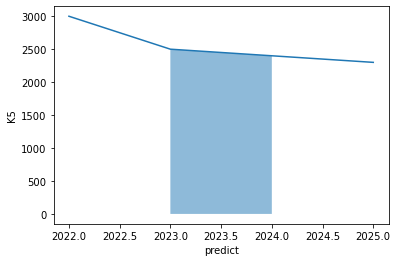

In [35]:
import matplotlib.pyplot as plt

x = [2022, 2023, 2024, 2025]
y = [3000, 2500, 2400, 2300]

plt.plot(x, y)
plt.xlabel('predict')
plt.ylabel('K5')
plt.fill_between(x[1:3], y[1:3], alpha=0.5)

plt.show()